In [ ]:
import random
import string
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives import padding
from cryptography.hazmat.backends import default_backend
import os
import csv

def generate_sentence():
    characters = string.ascii_letters + " " + string.digits + string.punctuation
    sentence = ''
    while len(sentence) < 50:
        char = random.choice(characters)
        sentence += char
    return sentence

# Function to encrypt plaintext using ECB mode
def encrypt_ecb(key, plaintext):
    padder = padding.PKCS7(256).padder()
    padded_plaintext = padder.update(plaintext) + padder.finalize()
    cipher = Cipher(algorithms.AES(key), modes.ECB(), backend=default_backend())
    encryptor = cipher.encryptor()
    return encryptor.update(padded_plaintext) + encryptor.finalize()

# Function to encrypt plaintext using CBC mode
def encrypt_cbc(key, plaintext,iv):
    padder = padding.PKCS7(256).padder()
    padded_plaintext = padder.update(plaintext) + padder.finalize()
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=default_backend())
    encryptor = cipher.encryptor()
    return iv + encryptor.update(padded_plaintext) + encryptor.finalize()

# Function to encrypt plaintext using OFB mode
def encrypt_ofb(key, plaintext,iv):
    cipher = Cipher(algorithms.AES(key), modes.OFB(iv), backend=default_backend())
    encryptor = cipher.encryptor()
    return iv + encryptor.update(plaintext)

# Single key for encryption
key = os.urandom(16)

num_sentences = 350

data = []

for i in range(num_sentences):
    plain_text = generate_sentence()
    iv = os.urandom(16)
    for j in range(3):
        if j == 0:
            Encryptedtext = encrypt_ecb(key, plain_text.encode())
            data.append({'Plaintext':plain_text,'key':key,'iv':'NONE','Encryptedtext':Encryptedtext, "Mode":"ECB"})
        elif j == 1:
            Encryptedtext = encrypt_cbc(key, plain_text.encode(),iv)
            data.append({'Plaintext':plain_text,'key':key,'iv':iv,'Encryptedtext':Encryptedtext, "Mode":"CBC"})

        else:
            Encryptedtext = encrypt_ofb(key, plain_text.encode(),iv)
            data.append({'Plaintext':plain_text,'key':key,'iv':iv,'Encryptedtext':Encryptedtext, "Mode":"OFB"})

field_names=['Plaintext','key','iv','Encryptedtext',"Mode"]

# Save encrypted data into a CSV file
with open('dataset_8.csv', mode="w", newline="") as file:
    writer = csv.DictWriter(file, fieldnames=field_names)

    # Write header
    writer.writeheader()

    # Write rows
    for row in data:
        writer.writerow(row)

print('dataset created')


dataset created


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.metrics import Precision, Recall, F1Score
from tensorflow.keras.utils import to_categorical

p = 0.1  # Set the probability of applying a random cut

def random_cuts(x):
    if np.random.random() < p:
        cut_length = np.random.randint(1, int(len(x) * 0.2))  # Randomly select a cut length
        start = np.random.randint(0, len(x) - cut_length)  # Randomly select a start position
        x = np.concatenate((x[:start], x[start+cut_length:]))  # Perform the random cut
    return x

def load_pretrained_embeddings(tokenizer, embedding_dim, embedding_path):
    embeddings_index = {}
    with open(embedding_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if i >= embedding_matrix.shape[0]:
            break
        if word in embeddings_index:
            embedding_matrix[i] = embeddings_index[word]

    return embedding_matrix

def load_pretrained_model(input_shape, num_classes):
    base_model = VGG16(include_top=False, input_shape=input_shape, weights='imagenet')
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

def evaluate_model(model, X_test, y_test):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    print(classification_report(y_test, y_pred))

# Load the dataset
data = pd.read_csv('dataset_8.csv')

# Preprocess the data
label_encoder = LabelEncoder()
data['Mode'] = label_encoder.fit_transform(data['Mode'])

# Tokenize the plaintext sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Plaintext'])
X = tokenizer.texts_to_sequences(data['Plaintext'])
X = pad_sequences(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, data['Mode'], test_size=0.2, random_state=42)

# Add pre-trained word embeddings
embedding_path = "/content/drive/MyDrive/ModelWeights/glove.6B.100d.txt"
embedding_dim = 100
embedding_matrix = load_pretrained_embeddings(tokenizer, embedding_dim, embedding_path)

# Build the deep learning model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=X.shape[1], weights=[embedding_matrix], trainable=True))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(GRU(128, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[
    'accuracy', Precision(name='precision'), Recall(name='recall'), F1Score(name='f1_score')
])
# Data augmentation
X_train, y_train = random_cuts(X_train), y_train

# Convert y_train to categorical format
y_train = pd.get_dummies(y_train).values

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1, callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
model.load_weights('best_model.h5')
loss, accuracy, precision, recall, f1_score = model.evaluate(X_test, to_categorical(y_test, num_classes=3))
print(f'Accuracy: {accuracy*100:.2f}%')
print(f'Precision: {precision*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')
print(f'F1 Score: {f1_score*100:.2f}%')

# Make predictions
predictions = model.predict(X_test)

Epoch 1/10


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1155, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1249, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 620, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/metrics_utils.py", line 77, in decorated
        result = update_state_fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/metrics/f_score_metrics.py", line 176, in update_state  **
        y_true = tf.convert_to_tensor(y_true, dtype=self.dtype)

    ValueError: Tensor conversion requested dtype float32 for Tensor with dtype bool: <tf.Tensor 'IteratorGetNext:1' shape=(None, 3) dtype=bool>


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Dataset Loading
data = pd.read_csv("/content/dataset_8.csv")

# Preprocessing
X = data[['Plaintext', 'Encryptedtext']]
y = data['Mode']

# Encode the string labels to numeric labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Feature Vectorization
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train['Plaintext'] + X_train['Encryptedtext'])
X_test_vectorized = vectorizer.transform(X_test['Plaintext'] + X_test['Encryptedtext'])

# Models (Specify the ones you want to focus on)
classifiers = {

    'Gradient Boosting': {
        'model': GradientBoostingClassifier(),
        'params': {
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5, 7],
            'n_estimators': [100, 200],
        }
    }
}

# Training, Evaluation, and Metrics
for model_name, classifier in classifiers.items():
    model = classifier['model']
    params = classifier['params']

    grid_search = GridSearchCV(estimator=model, param_grid=params, scoring='accuracy', cv=3)
    grid_search.fit(X_train_vectorized, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_vectorized)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=None)  # Calculate for each class
    recall = recall_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average='macro')  # Macro average for multiclass

    print(f"{model_name} Accuracy:", accuracy)
    print("Best Parameters:", grid_search.best_params_)
    print("Precision (ECB):", precision[0])  # Assuming 'ECB' is the first class
    print("Precision (CBC):", precision[1])
    print("Precision (OFB):", precision[2])
    print("Recall (ECB):", recall[0])
    print("Recall (CBC):", recall[1])
    print("Recall (OFB):", recall[2])
    print("F1-Score (Avg):", f1)
    print("-" * 20)  # Add a separator between models


Gradient Boosting Accuracy: 0.3476190476190476
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Precision (ECB): 1.0
Precision (CBC): 0.35789473684210527
Precision (OFB): 0.3090909090909091
Recall (ECB): 0.0684931506849315
Recall (CBC): 0.4788732394366197
Recall (OFB): 0.5151515151515151
F1-Score (Avg): 0.30806910626187733
--------------------


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Dataset Loading
data = pd.read_csv("/content/dataset_8.csv")

# Preprocessing
X = data[['Plaintext', 'Encryptedtext']]
y = data['Mode']

# Encode the string labels to numeric labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Feature Vectorization
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train['Plaintext'] + X_train['Encryptedtext'])
X_test_vectorized = vectorizer.transform(X_test['Plaintext'] + X_test['Encryptedtext'])

# Models (Specify the ones you want to focus on)
classifiers = {

    'SVM-RBF': {
        'model': SVC(kernel='rbf'),
        'params': {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto'],
        }
    },

}

# Training, Evaluation, and Metrics
for model_name, classifier in classifiers.items():
    model = classifier['model']
    params = classifier['params']

    grid_search = GridSearchCV(estimator=model, param_grid=params, scoring='accuracy', cv=3)
    grid_search.fit(X_train_vectorized, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_vectorized)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=None)  # Calculate for each class
    recall = recall_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average='macro')  # Macro average for multiclass

    print(f"{model_name} Accuracy:", accuracy)
    print("Best Parameters:", grid_search.best_params_)
    print("Precision (ECB):", precision[0])  # Assuming 'ECB' is the first class
    print("Precision (CBC):", precision[1])
    print("Precision (OFB):", precision[2])
    print("Recall (ECB):", recall[0])
    print("Recall (CBC):", recall[1])
    print("Recall (OFB):", recall[2])
    print("F1-Score (Avg):", f1)
    print("-" * 20)  # Add a separator between models


SVM-RBF Accuracy: 0.3142857142857143
Best Parameters: {'C': 0.1, 'gamma': 'scale'}
Precision (ECB): 0.0
Precision (CBC): 0.0
Precision (OFB): 0.3142857142857143
Recall (ECB): 0.0
Recall (CBC): 0.0
Recall (OFB): 1.0
F1-Score (Avg): 0.15942028985507248
--------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Dataset Loading
data = pd.read_csv("/content/dataset_8.csv")

# Preprocessing
X = data[['Plaintext', 'Encryptedtext']]
y = data['Mode']

# Encode the string labels to numeric labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Feature Vectorization
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train['Plaintext'] + X_train['Encryptedtext'])
X_test_vectorized = vectorizer.transform(X_test['Plaintext'] + X_test['Encryptedtext'])

# Models (Specify the ones you want to focus on)
classifiers = {

    'AdaBoost': {
        'model': AdaBoostClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1],
        }
    }
}

# Training, Evaluation, and Metrics
for model_name, classifier in classifiers.items():
    model = classifier['model']
    params = classifier['params']

    grid_search = GridSearchCV(estimator=model, param_grid=params, scoring='accuracy', cv=3)
    grid_search.fit(X_train_vectorized, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_vectorized)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=None)  # Calculate for each class
    recall = recall_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average='macro')  # Macro average for multiclass

    print(f"{model_name} Accuracy:", accuracy)
    print("Best Parameters:", grid_search.best_params_)
    print("Precision (ECB):", precision[0])  # Assuming 'ECB' is the first class
    print("Precision (CBC):", precision[1])
    print("Precision (OFB):", precision[2])
    print("Recall (ECB):", recall[0])
    print("Recall (CBC):", recall[1])
    print("Recall (OFB):", recall[2])
    print("F1-Score (Avg):", f1)
    print("-" * 20)  # Add a separator between models


AdaBoost Accuracy: 0.4238095238095238
Best Parameters: {'learning_rate': 0.1, 'n_estimators': 200}
Precision (ECB): 0.8666666666666667
Precision (CBC): 0.41414141414141414
Precision (OFB): 0.3645833333333333
Recall (ECB): 0.1780821917808219
Recall (CBC): 0.5774647887323944
Recall (OFB): 0.5303030303030303
F1-Score (Avg): 0.40330208402103823
--------------------


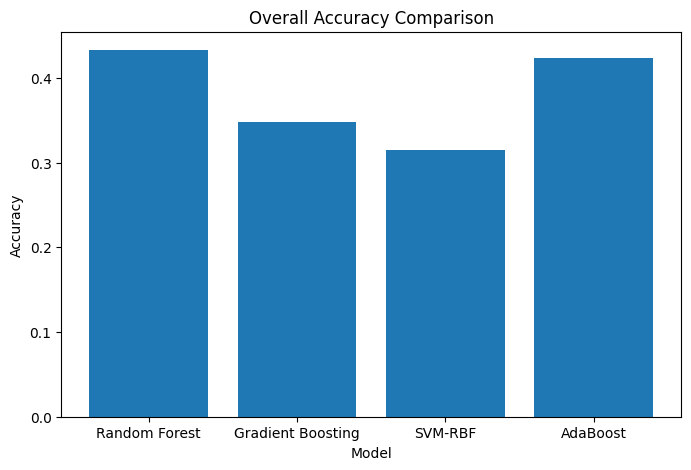

ValueError: Could not interpret value `Value` for `y`. An entry with this name does not appear in `data`.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# =========================
#  Data Preparation
# =========================

# Model Accuracies
models = ['Random Forest', 'Gradient Boosting', 'SVM-RBF', 'AdaBoost']
accuracies = [0.432857, 0.347619, 0.314286, 0.42381]

# Class-wise metrics
metrics_data = {
        'Model': ['RF', 'RF', 'RF', 'GB', 'GB', 'GB', 'SVM', 'SVM', 'SVM', 'Ada', 'Ada', 'Ada'],
        'Metric': ['Precision', 'Recall', 'F1-Score'] * 4,
        'ECB': [0.642578, 0.471347, 0.389684, 1.0, 0.068493, 0.308069, 0.0, 0.0, 0.15942, 0.866667, 0.178082, 0.403302],
        'CBC': [0.375268, 0.766423, 0.389684, 0.357895, 0.478873, 0.308069, 0.0, 0.0, 0.15942, 0.414141, 0.577465, 0.403302],
        'OFB': [0.291005, 0.076709, 0.389684, 0.309091, 0.515152, 0.308069, 0.314286, 1.0, 0.15942, 0.364583, 0.530303, 0.403302]}

# =========================
#  Graph Plotting
# =========================

# Overall Accuracy Comparison
plt.figure(figsize=(8, 5))
plt.bar(models, accuracies)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Overall Accuracy Comparison")
plt.show()

# Class-wise Metric Comparison
df = pd.DataFrame(metrics_data)
sns.barplot(x='Model', y='Value', hue='Metric', data=df, palette='tab10')
plt.title("Performance Metrics per Model and Encryption Mode")
plt.xlabel("Model")
plt.ylabel("Score")
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Dataset Loading
data = pd.read_csv("/content/dataset_8.csv")

# Preprocessing
X = data[['Plaintext', 'Encryptedtext']]
y = data['Mode']

# Encode the string labels to numeric labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Feature Vectorization
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train['Plaintext'] + X_train['Encryptedtext'])
X_test_vectorized = vectorizer.transform(X_test['Plaintext'] + X_test['Encryptedtext'])

# Models (Specify the ones you want to focus on)
classifiers = {
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7],
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(),
        'params': {
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5, 7],
            'n_estimators': [100, 200],
        }
    },
    'SVM-RBF': {
        'model': SVC(kernel='rbf'),
        'params': {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto'],
        }
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1],
        }
    }
}

# Training, Evaluation, and Metrics
for model_name, classifier in classifiers.items():
    model = classifier['model']
    params = classifier['params']

    grid_search = GridSearchCV(estimator=model, param_grid=params, scoring='accuracy', cv=3)
    grid_search.fit(X_train_vectorized, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_vectorized)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=None)  # Calculate for each class
    recall = recall_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average='macro')  # Macro average for multiclass

    print(f"{model_name} Accuracy:", accuracy)
    print("Best Parameters:", grid_search.best_params_)
    print("Precision (ECB):", precision[0])  # Assuming 'ECB' is the first class
    print("Precision (CBC):", precision[1])
    print("Precision (OFB):", precision[2])
    print("Recall (ECB):", recall[0])
    print("Recall (CBC):", recall[1])
    print("Recall (OFB):", recall[2])
    print("F1-Score (Avg):", f1)
    print("-" * 20)  # Add a separator between models


Random Forest Accuracy: 0.3476190476190476
Best Parameters: {'max_depth': 7, 'n_estimators': 50}
Precision (ECB): 0.7777777777777778
Precision (CBC): 0.35353535353535354
Precision (OFB): 0.30392156862745096
Recall (ECB): 0.0958904109589041
Recall (CBC): 0.49295774647887325
Recall (OFB): 0.4696969696969697
F1-Score (Avg): 0.3171813440823484
--------------------
Gradient Boosting Accuracy: 0.3476190476190476
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Precision (ECB): 0.7142857142857143
Precision (CBC): 0.3904761904761905
Precision (OFB): 0.2755102040816326
Recall (ECB): 0.0684931506849315
Recall (CBC): 0.5774647887323944
Recall (OFB): 0.4090909090909091
F1-Score (Avg): 0.30672579453067256
--------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM-RBF Accuracy: 0.3142857142857143
Best Parameters: {'C': 0.1, 'gamma': 'scale'}
Precision (ECB): 0.0
Precision (CBC): 0.0
Precision (OFB): 0.3142857142857143
Recall (ECB): 0.0
Recall (CBC): 0.0
Recall (OFB): 1.0
F1-Score (Avg): 0.15942028985507248
--------------------
AdaBoost Accuracy: 0.36666666666666664
Best Parameters: {'learning_rate': 0.1, 'n_estimators': 200}
Precision (ECB): 0.6153846153846154
Precision (CBC): 0.41025641025641024
Precision (OFB): 0.31092436974789917
Recall (ECB): 0.1095890410958904
Recall (CBC): 0.4507042253521127
Recall (OFB): 0.5606060606060606
F1-Score (Avg): 0.338525570990063
--------------------


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# =========================
#  Data Preparation
# =========================

# Model Accuracies
models = ['Random Forest', 'Gradient Boosting', 'SVM-RBF', 'AdaBoost']
accuracies = [0.432857, 0.347619, 0.314286, 0.42381]

# Class-wise metrics
metrics_data = {
        'Model': ['RF', 'RF', 'RF', 'GB', 'GB', 'GB', 'SVM', 'SVM', 'SVM', 'Ada', 'Ada', 'Ada'],
        'Metric': ['Precision', 'Recall', 'F1-Score'] * 4,
        'ECB': [0.642578, 0.471347, 0.389684, 1.0, 0.068493, 0.308069, 0.0, 0.0, 0.15942, 0.866667, 0.178082, 0.403302],
        'CBC': [0.375268, 0.766423, 0.389684, 0.357895, 0.478873, 0.308069, 0.0, 0.0, 0.15942, 0.414141, 0.577465, 0.403302],
        'OFB': [0.291005, 0.076709, 0.389684, 0.309091, 0.515152, 0.308069, 0.314286, 1.0, 0.15942, 0.364583, 0.530303, 0.403302]}

# =========================
#  Graph Plotting
# =========================

# Overall Accuracy Comparison
plt.figure(figsize=(8, 5))
plt.bar(models, accuracies)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Overall Accuracy Comparison")
plt.show()

# Class-wise Metric Comparison
df = pd.DataFrame(metrics_data)
sns.barplot(x='Model', y="Value", hue='Metric', data=df, palette='tab10')
plt.title("Performance Metrics per Model and Encryption Mode")
plt.xlabel("Model")
plt.ylabel("Score")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the dataset
data = pd.read_csv('dataset_8.csv')

# Preprocess the data
label_encoder = LabelEncoder()
data['Mode'] = label_encoder.fit_transform(data['Mode'])

# Tokenize the plaintext sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Plaintext'])
X = tokenizer.texts_to_sequences(data['Plaintext'])
X = pad_sequences(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, data['Mode'], test_size=0.2, random_state=42)

# Build the deep learning model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(GRU(128, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1, callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
model.load_weights('best_model.h5')
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy*100:.2f}%')

# Make predictions
predictions = model.predict(X_test)

Epoch 1/10
12/12 [==============================] - 12s 285ms/step - loss: 1.1067 - accuracy: 0.3069 - val_loss: 1.1155 - val_accuracy: 0.2143
Epoch 2/10
 1/12 [=>............................] - ETA: 1s - loss: 1.1043 - accuracy: 0.2969

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 2s 154ms/step - loss: 1.1000 - accuracy: 0.3532 - val_loss: 1.1400 - val_accuracy: 0.2143
Epoch 3/10
12/12 [==============================] - 2s 161ms/step - loss: 1.0939 - accuracy: 0.3611 - val_loss: 1.1273 - val_accuracy: 0.0952
Epoch 4/10
12/12 [==============================] - 2s 168ms/step - loss: 1.0884 - accuracy: 0.3942 - val_loss: 1.1543 - val_accuracy: 0.0476
Epoch 5/10
12/12 [==============================] - 2s 138ms/step - loss: 1.0743 - accuracy: 0.4220 - val_loss: 1.2448 - val_accuracy: 0.0357
Epoch 6/10
7/7 [==============================] - 0s 12ms/step - loss: 1.1074 - accuracy: 0.3143
Accuracy: 31.43%
7/7 [==============================] - 1s 13ms/step


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SpatialDropout1D, Bidirectional, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the dataset
data = pd.read_csv('dataset_8.csv')

# Preprocess the data
label_encoder = LabelEncoder()
data['Mode'] = label_encoder.fit_transform(data['Mode'])

# Tokenize the plaintext sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Plaintext'])
X = tokenizer.texts_to_sequences(data['Plaintext'])
X = pad_sequences(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, data['Mode'], test_size=0.2, random_state=42)

# Build the deep learning model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(GRU(128, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1, callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
model.load_weights('best_model.h5')
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy*100:.2f}%')

# Make predictions
predictions = model.predict(X_test)

# Calculate evaluation metrics
y_pred_classes = np.argmax(predictions, axis=1)
precision = precision_score(y_test, y_pred_classes, average=None)
recall = recall_score(y_test, y_pred_classes, average=None)
f1 = f1_score(y_test, y_pred_classes, average='macro')

# Print the metrics
model_name = 'Bidirectional GRU'
print(f"{model_name} Accuracy: {accuracy*100:.2f}%")
print("Precision (ECB):", precision[0])
print("Precision (CBC):", precision[1])
print("Precision (OFB):", precision[2])
print("Recall (ECB):", recall[0])
print("Recall (CBC):", recall[1])
print("Recall (OFB):", recall[2])
print("F1-Score (Avg):", f1)
print("-" * 20)  # Add a separator between models


Epoch 1/10
12/12 [==============================] - 19s 240ms/step - loss: 1.1028 - accuracy: 0.3333 - val_loss: 1.1184 - val_accuracy: 0.2143
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 2s 175ms/step - loss: 1.0979 - accuracy: 0.3585 - val_loss: 1.1199 - val_accuracy: 0.2143
Epoch 3/10
12/12 [==============================] - 3s 259ms/step - loss: 1.0920 - accuracy: 0.4127 - val_loss: 1.1327 - val_accuracy: 0.0952
Epoch 4/10
12/12 [==============================] - 2s 187ms/step - loss: 1.0864 - accuracy: 0.3942 - val_loss: 1.1680 - val_accuracy: 0.0714
Epoch 5/10
12/12 [==============================] - 2s 126ms/step - loss: 1.0704 - accuracy: 0.4114 - val_loss: 1.2896 - val_accuracy: 0.0476
Epoch 6/10
7/7 [==============================] - 0s 19ms/step - loss: 1.1095 - accuracy: 0.3143
Accuracy: 31.43%
7/7 [==============================] - 1s 13ms/step
Bidirectional GRU Accuracy: 31.43%
Precision (ECB): 0.0
Precision (CBC): 0.0
Precision (OFB): 0.3142857142857143
Recall (ECB): 0.0
Recall (CBC): 0.0
Recall (OFB): 1.0
F1-Score (Avg): 0.15942028985507248
--------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<ipython-input-2-a5db70a2ea46>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_values, y=metrics_names, palette='viridis')


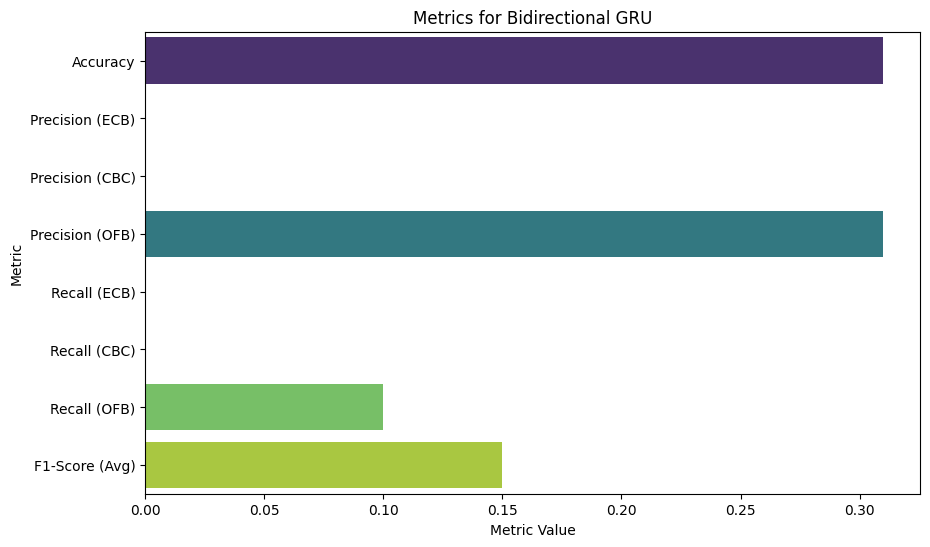

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the model name and evaluation metrics
model_name = 'Bidirectional GRU'
accuracy = 0.31
precision_ecb = 0.0
precision_cbc = 0.0
precision_ofb = 0.31
recall_ecb = 0.0
recall_cbc = 0.0
recall_ofb = .10
f1_avg = 0.15

# Plotting the metrics
metrics_names = ['Accuracy', 'Precision (ECB)', 'Precision (CBC)', 'Precision (OFB)',
                 'Recall (ECB)', 'Recall (CBC)', 'Recall (OFB)', 'F1-Score (Avg)']
metrics_values = [accuracy, precision_ecb, precision_cbc, precision_ofb,
                  recall_ecb, recall_cbc, recall_ofb, f1_avg]

plt.figure(figsize=(10, 6))
sns.barplot(x=metrics_values, y=metrics_names, palette='viridis')
plt.title(f'Metrics for {model_name}')
plt.xlabel('Metric Value')
plt.ylabel('Metric')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Data Loading and Preprocessing
df = pd.read_csv("dataset_8.csv")
X = df['Encryptedtext'].values  # Removed.decode() since data is already in string format
y = df['Mode'].values

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
max_len = max([len(seq) for seq in sequences])
X_padded = pad_sequences(sequences, maxlen=max_len, padding='post')

# Convert string labels to integers
encoder = LabelEncoder()
y_int = encoder.fit_transform(y)

# Convert labels to categorical
y_encoded = to_categorical(y_int)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)

# Step 2: Feature Engineering/Extraction
vocab_size = len(tokenizer.word_index) + 1

# Step 3: CNN Model Architecture
model = Sequential([
    Embedding(vocab_size, 100, input_length=max_len),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes for ECB, CBC, OFB
])

# Step 4: Model Training
model.compile(loss=CategoricalCrossentropy(), optimizer=AdamW(lr=0.001), metrics=[Accuracy()])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Step 5: Model Evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

# Predictions and Confusion Matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

print(classification_report(np.argmax(y_test, axis=1), y_pred))


Epoch 1/10
27/27 [==============================] - 11s 203ms/step - loss: 1.0416 - accuracy: 0.0000e+00 - val_loss: 0.8684 - val_accuracy: 0.0000e+00
Epoch 2/10
27/27 [==============================] - 4s 132ms/step - loss: 0.7186 - accuracy: 0.0000e+00 - val_loss: 0.6553 - val_accuracy: 0.0000e+00
Epoch 3/10
27/27 [==============================] - 1s 43ms/step - loss: 0.5994 - accuracy: 0.0000e+00 - val_loss: 0.6700 - val_accuracy: 0.0000e+00
Epoch 4/10
27/27 [==============================] - 1s 48ms/step - loss: 0.5223 - accuracy: 0.0000e+00 - val_loss: 0.6802 - val_accuracy: 0.0000e+00
Epoch 5/10
27/27 [==============================] - 1s 32ms/step - loss: 0.3678 - accuracy: 0.0000e+00 - val_loss: 0.8310 - val_accuracy: 0.0000e+00
Epoch 6/10
27/27 [==============================] - 2s 60ms/step - loss: 0.1796 - accuracy: 3.9683e-04 - val_loss: 0.9616 - val_accuracy: 0.0000e+00
Epoch 7/10
27/27 [==============================] - 1s 25ms/step - loss: 0.0683 - accuracy: 0.0016 - va

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

Epoch 1/10
27/27 [==============================] - 7s 98ms/step - loss: 1.0381 - accuracy: 0.0000e+00 - val_loss: 0.8664 - val_accuracy: 0.0000e+00
Epoch 2/10
27/27 [==============================] - 2s 63ms/step - loss: 0.7352 - accuracy: 0.0000e+00 - val_loss: 0.6697 - val_accuracy: 0.0000e+00
Epoch 3/10
27/27 [==============================] - 1s 54ms/step - loss: 0.6297 - accuracy: 0.0000e+00 - val_loss: 0.6729 - val_accuracy: 0.0000e+00
Epoch 4/10
27/27 [==============================] - 1s 29ms/step - loss: 0.5749 - accuracy: 0.0000e+00 - val_loss: 0.6878 - val_accuracy: 0.0000e+00
Epoch 5/10
27/27 [==============================] - 1s 26ms/step - loss: 0.4289 - accuracy: 0.0000e+00 - val_loss: 0.7377 - val_accuracy: 0.0000e+00
Epoch 6/10
27/27 [==============================] - 1s 31ms/step - loss: 0.2244 - accuracy: 0.0000e+00 - val_loss: 0.8830 - val_accuracy: 0.0000e+00
Epoch 7/10
27/27 [==============================] - 1s 23ms/step - loss: 0.0597 - accuracy: 0.0000e+00 - v

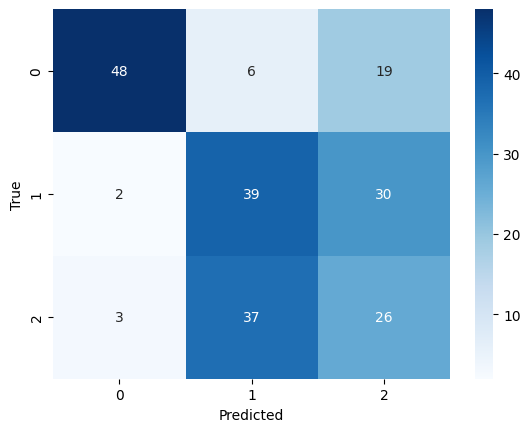

              precision    recall  f1-score   support

           0       0.91      0.66      0.76        73
           1       0.48      0.55      0.51        71
           2       0.35      0.39      0.37        66

    accuracy                           0.54       210
   macro avg       0.58      0.53      0.55       210
weighted avg       0.58      0.54      0.55       210



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Data Loading and Preprocessing
df = pd.read_csv("dataset_8.csv")
X = df['Encryptedtext'].values  # Removed .decode() since data is already in string format
y = df['Mode'].values

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
max_len = max([len(seq) for seq in sequences])
X_padded = pad_sequences(sequences, maxlen=max_len, padding='post')

# Convert string labels to integers
encoder = LabelEncoder()
y_int = encoder.fit_transform(y)

# Convert labels to categorical
y_encoded = to_categorical(y_int)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)

# Step 2: Feature Engineering/Extraction
vocab_size = len(tokenizer.word_index) + 1

# Step 3: CNN Model Architecture
model = Sequential([
    Embedding(vocab_size, 100, input_length=max_len),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes for ECB, CBC, OFB
])

# Step 4: Model Training
model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(lr=0.001), metrics=[Accuracy()])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Step 5: Model Evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

# Predictions and Confusion Matrix
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_labels, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y_test_labels, y_pred))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Data Loading and Preprocessing
df = pd.read_csv("dataset_8.csv")
X = df['Encryptedtext'].values
y = df['Mode'].values

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
max_len = max([len(seq) for seq in sequences])
X_padded = pad_sequences(sequences, maxlen=max_len, padding='post')

# Convert string labels to integers
encoder = LabelEncoder()
y_int = encoder.fit_transform(y)

# Convert labels to categorical
y_encoded = to_categorical(y_int)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=100)  # Choose the number of components to keep
X_pca = pca.fit_transform(X_padded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=42)

# Step 2: Feature Engineering/Extraction
vocab_size = len(tokenizer.word_index) + 1

# Step 3: CNN Model Architecture
model = Sequential([
    Embedding(vocab_size, 100, input_length=100),  # input_length adjusted to match PCA components
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes for ECB, CBC, OFB
])

# Step 4: Model Training
model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(lr=0.001), metrics=[Accuracy()])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Step 5: Model Evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

# Predictions and Confusion Matrix
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_labels, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y_test_labels, y_pred))


ValueError: n_components=100 must be between 0 and min(n_samples, n_features)=64 with svd_solver='full'

Epoch 1/10
27/27 [==============================] - 11s 179ms/step - loss: 1.1045 - accuracy: 0.0000e+00 - val_loss: 1.0986 - val_accuracy: 0.0000e+00
Epoch 2/10
27/27 [==============================] - 3s 96ms/step - loss: 1.0872 - accuracy: 0.0000e+00 - val_loss: 1.0988 - val_accuracy: 0.0000e+00
Epoch 3/10
27/27 [==============================] - 2s 78ms/step - loss: 1.0539 - accuracy: 0.0000e+00 - val_loss: 1.0951 - val_accuracy: 0.0000e+00
Epoch 4/10
27/27 [==============================] - 2s 62ms/step - loss: 0.9301 - accuracy: 0.0000e+00 - val_loss: 1.0897 - val_accuracy: 0.0000e+00
Epoch 5/10
27/27 [==============================] - 1s 54ms/step - loss: 0.5793 - accuracy: 0.0000e+00 - val_loss: 1.1447 - val_accuracy: 0.0000e+00
Epoch 6/10
27/27 [==============================] - 2s 59ms/step - loss: 0.1714 - accuracy: 0.0000e+00 - val_loss: 1.3542 - val_accuracy: 0.0000e+00
Epoch 7/10
27/27 [==============================] - 1s 27ms/step - loss: 0.0441 - accuracy: 0.0000e+00 -

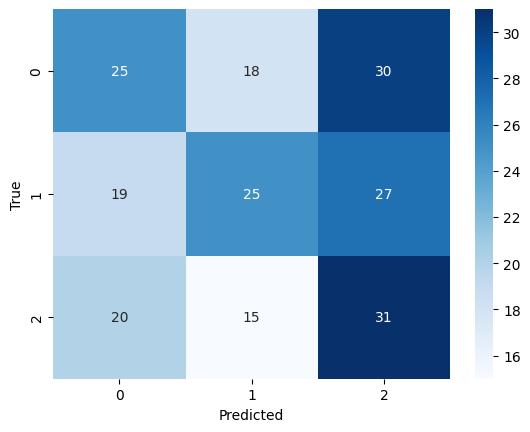

              precision    recall  f1-score   support

           0       0.39      0.34      0.36        73
           1       0.43      0.35      0.39        71
           2       0.35      0.47      0.40        66

    accuracy                           0.39       210
   macro avg       0.39      0.39      0.39       210
weighted avg       0.39      0.39      0.38       210



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Data Loading and Preprocessing
df = pd.read_csv("dataset_8.csv")
X = df['Encryptedtext'].values
y = df['Mode'].values

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
max_len = max([len(seq) for seq in sequences])
X_padded = pad_sequences(sequences, maxlen=max_len, padding='post')

# Convert string labels to integers
encoder = LabelEncoder()
y_int = encoder.fit_transform(y)

# Convert labels to categorical
y_encoded = to_categorical(y_int)

# Apply PCA to reduce dimensionality
n_components = 50  # Adjusted number of components to a valid value
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_padded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=42)

# Step 2: Feature Engineering/Extraction
vocab_size = len(tokenizer.word_index) + 1

# Step 3: CNN Model Architecture
model = Sequential([
    Embedding(vocab_size, 100, input_length=n_components),  # input_length adjusted to match PCA components
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes for ECB, CBC, OFB
])

# Step 4: Model Training
model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(lr=0.001), metrics=[Accuracy()])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Step 5: Model Evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

# Predictions and Confusion Matrix
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_labels, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y_test_labels, y_pred))
